# Ensembles of Models

## 1. Bagging

### Loading Dataset

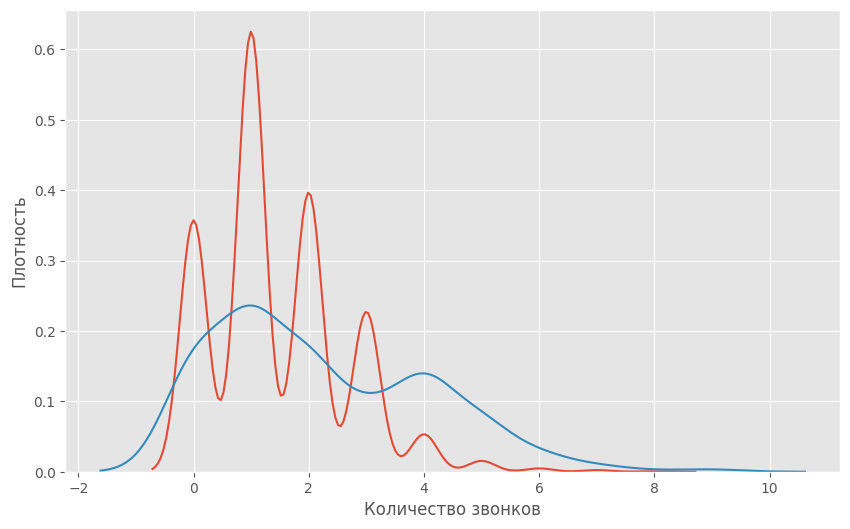

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

URL = 'https://drive.google.com/uc?id=1U9LC5ECI2_Jvq4FrZNCOn3gCT7T5Y5DD'
telecom_data = pd.read_csv(URL)

fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label='Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label='Churn')

fig.set(xlabel='Количество звонков', ylabel='Плотность')
plt.show()

### Data Sampling

In [7]:
import numpy as np


def get_bootstrap_samples(data, n_samples, n_data):
    indices = np.random.randint(0, len(data), (n_samples, n_data))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


n_samples = 3000
n_data = 600

loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls = telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

np.random.seed(0)

loyal_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(loyal_calls, n_samples, n_data)]
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn_calls, n_samples, n_data)]

print('Service calls from loyal: mean interval', stat_intervals(loyal_mean_scores, .05))
print('Service calls from churns: mean interval', stat_intervals(churn_mean_scores, .05))

print('Service calls from loyal: mean', np.mean(loyal_calls))
print('Service calls from churns: mean', np.mean(churn_calls))

Service calls from loyal: mean interval [1.356625   1.54833333]
Service calls from churns: mean interval [2.08495833 2.38666667]
Service calls from loyal: mean 1.4498245614035088
Service calls from churns: mean 2.229813664596273


### Fitting

<>:78: SyntaxWarning: invalid escape sequence '\^'
<>:78: SyntaxWarning: invalid escape sequence '\^'
C:\Users\Иван\AppData\Local\Temp\ipykernel_14920\1060330450.py:78: SyntaxWarning: invalid escape sequence '\^'
  plt.plot(X_test, y_predict[:, i], 'r', alpha=0.1, label='$\^y(x)$')


Tree         : 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging (Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


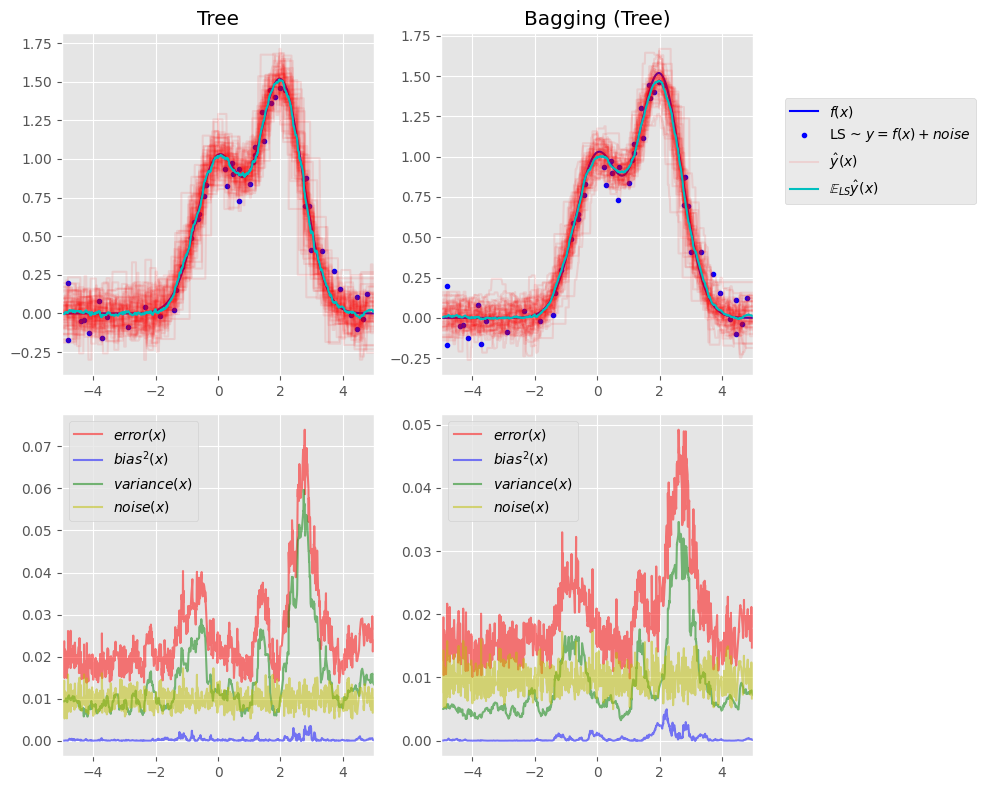

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

n_repeat = 50
n_train = 50
n_test = 1000
noise = .1
np.random.seed(0)

estimators = [('Tree', DecisionTreeRegressor()),
              ('Bagging (Tree)', BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_samples=1.0))]
n_estimators = len(estimators)


def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)
    
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)
    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test).ravel() - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print('{0:13}: {1:.4f} (error) = {2:.4f} (bias^2) '
          ' + {3:.4f} (var) + {4:.4f} (noise)'.format(name, np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))
    
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), 'b', label='$f(x)$')
    plt.plot(X_train[0], y_train[0], '.b', label='LS ~ $y = f(x) + noise$')

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], 'r', alpha=0.1, label='$\^y(x)$')
        else:
            plt.plot(X_test, y_predict[:, i], 'r', alpha=0.1)

    plt.plot(X_test, np.mean(y_predict, axis=1), 'c', label=r'$\mathbb{E}_{LS} \^y(x)$')
    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, 'r', label='$error(x)$', alpha=0.5)
    plt.plot(X_test, y_bias, 'b', label='$bias^2(x)$', alpha=0.5)
    plt.plot(X_test, y_var, 'g', label='$variance(x)$', alpha=0.5)
    plt.plot(X_test, y_noise, 'y', label='$noise(x)$', alpha=0.5)
    plt.xlim([-5, 5])
    plt.legend()

plt.tight_layout()
plt.show()

## 2. Stacking

### Dataset Generation and Fitting

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

def Div_plate(clf, flip_level):
    X, y = make_classification(n_samples=10000,
                               n_features=2,
                               n_informative=1,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               class_sep=1,
                               flip_y=flip_level,
                               weights=[.4, .6],
                               random_state=17)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
    plt.subplots();
    ax1 = plt.gca();
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, ax=ax1);
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, ax=ax1, marker='+');
    ax1.set_title('Data with noise');
    plt.show()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print('Score =', score)
    ind = y_test == y_pred
    plt.subplots();
    ax2 = plt.gca();
    sns.scatterplot(x=X_test[ind, 0], y=X_test[ind, 1], hue=y_test[ind], ax=ax2);
    sns.scatterplot(x=X_test[~ind, 0], y=X_test[~ind, 1], hue=y_pred[~ind], ax=ax2, marker='+');
    ax2.set_title('With Noise');
    plot_step = .01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, levels=1, collors=['blue', 'orange'], aplha=.3)
    plt.show()

### Setting up Models

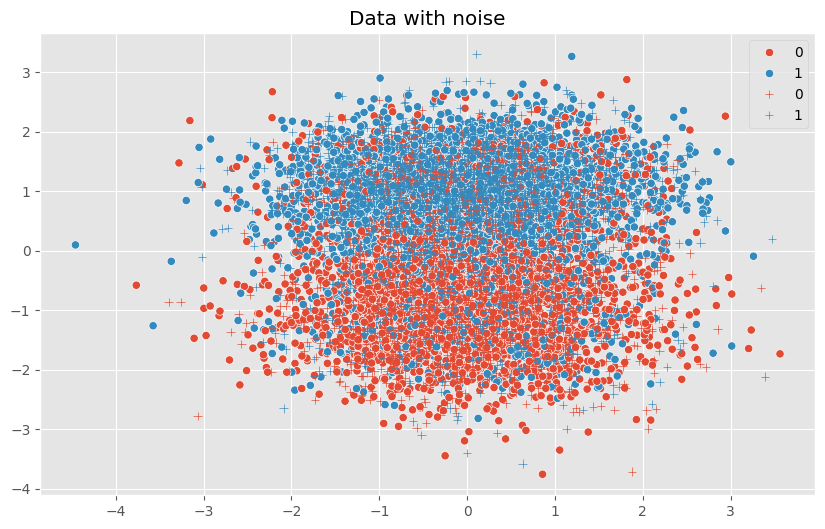

c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\Ap

Score = 0.7627272727272727


C:\Users\Иван\AppData\Local\Temp\ipykernel_14920\2769120624.py:42: UserWarning: The following kwargs were not used by contour: 'collors', 'aplha'
  cs = plt.contourf(xx, yy, Z, levels=1, collors=['blue', 'orange'], aplha=.3)


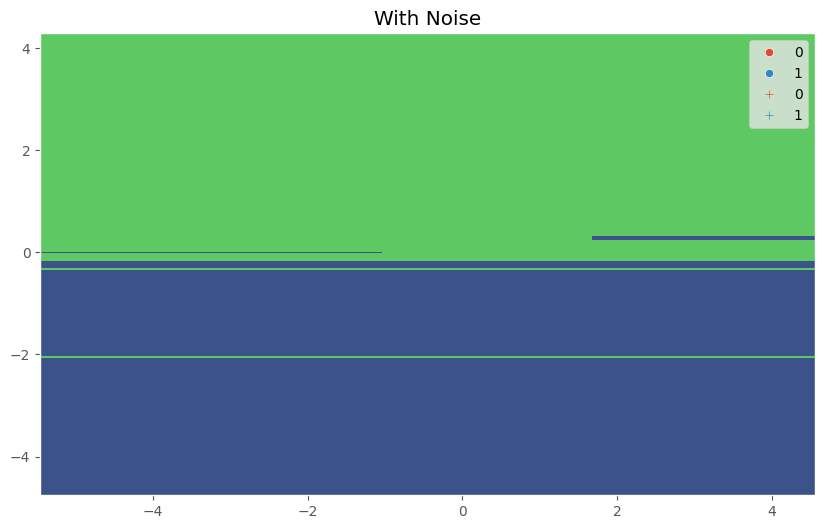

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


estimators = [('SVC', SVC(max_iter=10)),
              ('LogReg', LogisticRegression()),
              ('Tree', DecisionTreeClassifier(max_depth=5))]
clf = StackingClassifier(estimators=estimators)
flip_level = .4
Div_plate(clf, flip_level)

In [18]:
clf.final_estimator_.coef_

array([[-0.62198472,  2.49377763,  2.10981249]])